# Training exploration
Two lightweight baselines (nano/small) with quick epochs. Adjust DATASET_ROOT and hyperparams as needed.


In [9]:
%matplotlib inline
# Ensure notebook root directory is correct
from pathlib import Path
import random
import sys

# Normalize project root whether notebook is run from repo root or notebooks/
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))



In [ ]:
from src.training import train_model, evaluate_model
from src.config import Paths, TrainingConfig

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Choose dataset (change here to point to another YOLO-formatted set)
DATASET_ROOT = PROJECT_ROOT / "Poles2025/roadpoles_v1"
paths = Paths(dataset_root=DATASET_ROOT)
DATASET_ROOT


PosixPath('/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/roadpoles_v1')

In [11]:
# Define two models: one tiny, one small (both pretrained)
experiments = [
    {"name": "yolov8n_baseline", "model": "yolov8n.pt", "epochs": 3, "batch": 8, "imgsz": 640},
    {"name": "yolov8s_baseline", "model": "yolov8s.pt", "epochs": 3, "batch": 8, "imgsz": 640},
]
experiments


[{'name': 'yolov8n_baseline',
  'model': 'yolov8n.pt',
  'epochs': 3,
  'batch': 8,
  'imgsz': 640},
 {'name': 'yolov8s_baseline',
  'model': 'yolov8s.pt',
  'epochs': 3,
  'batch': 8,
  'imgsz': 640}]

In [12]:
# Train + eval loop (train on train, eval on val per data.yaml)
results = []
for exp in experiments:
    print(f"=== Training {exp['name']} ({exp['model']}) ===")
    cfg = TrainingConfig(
        model=exp["model"],
        epochs=exp["epochs"],
        batch=exp["batch"],
        imgsz=exp["imgsz"],
        patience=10,
    )
    train_res = train_model(paths=paths, cfg=cfg, overrides={"name": exp["name"]})

    # Locate best weights from this run
    best_weights = Path(train_res.save_dir) / "weights" / "best.pt"
    metrics = evaluate_model(
        weights=best_weights,
        paths=paths,
        imgsz=cfg.imgsz,
        batch=cfg.batch,
    )

    res_dict = getattr(metrics, "results_dict", {}) or {}
    results.append(
        {
            "name": exp["name"],
            "model": exp["model"],
            "train_time_s": getattr(train_res, "train_time_seconds", None),
            "eval_time_s": getattr(metrics, "eval_time_seconds", None),
            "precision": res_dict.get("metrics/precision(B)"),
            "recall": res_dict.get("metrics/recall(B)") ,
            "map50": res_dict.get("metrics/mAP50(B)"),
            "map5095": res_dict.get("metrics/mAP50-95(B)"),
            "save_dir": str(train_res.save_dir),
            "weights": str(best_weights),
        }
    )

results_df = pd.DataFrame(results)
results_df


=== Training yolov8n_baseline (yolov8n.pt) ===
New https://pypi.org/project/ultralytics/8.3.231 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.230 🚀 Python-3.13.5 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24208MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/roadpoles_v1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0,

,name,model,train_time_s,eval_time_s,precision,recall,map50,map5095,save_dir,weights
0,yolov8n_baseline,yolov8n.pt,8.75632,1.708438,0.600000,0.026549,0.313958,0.220117,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
1,yolov8s_baseline,yolov8s.pt,9.19380,1.910474,0.488829,0.477876,0.465148,0.214762,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...


## Notes
- Adjust epochs/batch/imgsz for real runs.
- Swap `DATASET_ROOT` to point at another YOLO dataset (e.g., the iPhone variant) without changing code.
- Results use Ultralytics defaults for val split and metrics (precision, recall, mAP@50, mAP@50-95).


## Performance analysis
Quick comparison of the two trained variants. Adjust as you rerun with different settings/models.

In [13]:
assert 'results_df' in globals(), 'Run the training cell first to populate results_df'
df = results_df.copy()
display(df.sort_values('map50', ascending=False))


,name,model,train_time_s,eval_time_s,precision,recall,map50,map5095,save_dir,weights
1,yolov8s_baseline,yolov8s.pt,9.19380,1.910474,0.488829,0.477876,0.465148,0.214762,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
0,yolov8n_baseline,yolov8n.pt,8.75632,1.708438,0.600000,0.026549,0.313958,0.220117,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...


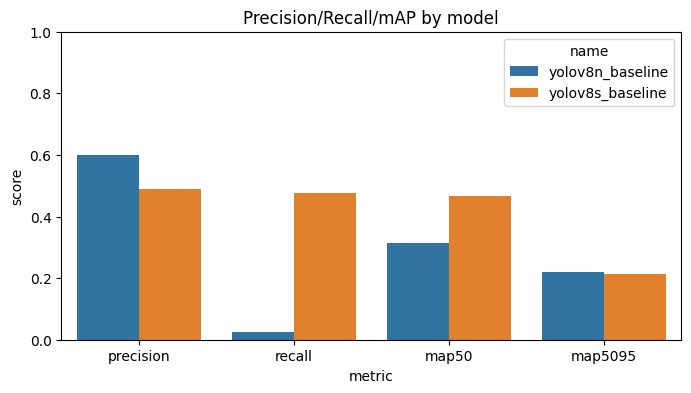

In [14]:
# Accuracy metrics comparison
plot_df = df.melt(id_vars=['name','model'], value_vars=['precision','recall','map50','map5095'], var_name='metric', value_name='score')
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=plot_df, x='metric', y='score', hue='name', ax=ax)
ax.set_title('Precision/Recall/mAP by model')
ax.set_ylim(0, 1)
plt.show()


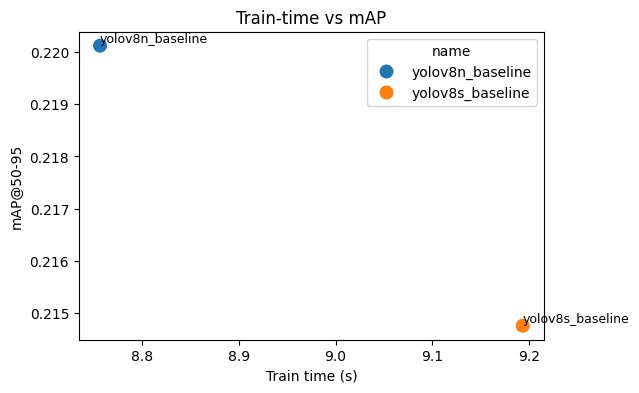

In [15]:
# Speed vs accuracy
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df, x='train_time_s', y='map5095', hue='name', s=120, ax=ax)
for _, row in df.iterrows():
    ax.text(row['train_time_s'], row['map5095'], row['name'], fontsize=9, ha='left', va='bottom')
ax.set_xlabel('Train time (s)')
ax.set_ylabel('mAP@50-95')
ax.set_title('Train-time vs mAP')
plt.show()


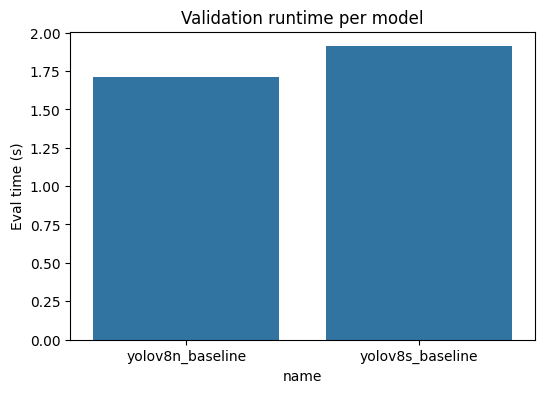

In [16]:
# Latency/throughput proxy from eval time
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=df, x='name', y='eval_time_s', ax=ax)
ax.set_ylabel('Eval time (s)')
ax.set_title('Validation runtime per model')
plt.show()


### Quick takeaways
- `yolov8s` should offer higher mAP at some extra train/eval time; confirm above.
- If gaps are small, prefer `yolov8n` for speed/edge use; if `map50`/`map50-95` jumps, keep `yolov8s` as main model.
- Rerun with more epochs and tuned batch/imgsz to get stable gaps before committing to a default.
